In [1]:
import numpy as np
import BigFunctions as BF
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import uproot as ur
#%matplotlib tk

In [2]:
#Reading the variables

input_path = "../data/bigdata_CFD_20092024_0001.root"
with ur.open(input_path) as file:
    outTree = file["DataTree"]
    label = outTree["label"].array(library = "np")
    time = outTree["time"].array(library = "np")*10**-6   #[µs]
    nrj = outTree["nrj"].array(library = "np")
    pileup = outTree["pileup"].array(library = "np")

print("Duration of the data acquisition:", max(time)*10**(-6)/3600, "hours")
print("Number of events acquired:", len(label)/10**6, "million")
print("Number of events acquired with PM2:", len(label[label == 2])/10**6, "million")

Duration of the data acquisition: 64.80661879629267 hours
Number of events acquired: 48.889578 million
Number of events acquired with PM2: 16.993348 million


In [3]:
#To see if there was aproblem during the data acquisition
print(time[label == 1][-50:-1]*10**(-6)/3600)
print(time[label == 2][-100:-1]*10**(-6)/3600)

[56.07125838 56.07125961 56.07126012 56.07126053 56.07126142 56.0712647
 56.07127201 56.07127221 56.07127367 56.07127919 56.07128151 56.07128151
 56.0712842  56.07128651 56.07129192 56.07129267 56.07129579 56.07130012
 56.07130577 56.0713068  56.07131459 56.07131547 56.07132429 56.07132555
 56.07132692 56.07132744 56.07132759 56.07132967 56.07133422 56.07133427
 56.07133936 56.07133936 56.07134    56.07134451 56.07134602 56.07134638
 56.07134729 56.07135143 56.07135166 56.07135755 56.07135918 56.07135967
 56.07136064 56.07297191 64.80658518 64.80658518 64.80659334 64.8065954
 64.8065954 ]
[24.15203931 24.15205155 24.15205528 24.1520561  24.15208079 24.15208452
 24.15210682 24.15213145 24.15213573 24.15217322 24.15218662 24.15224087
 24.1522768  24.15230276 24.15230563 24.15231086 24.1524586  24.15247583
 24.15255287 24.15293954 24.62782231 24.64451631 25.24831302 25.56695449
 25.62122821 25.94441635 26.06798883 26.09270303 26.18757073 26.19736301
 26.38911132 26.45799268 26.48103359 26

In [4]:
#Correlation

corr_t = 10*10**-3   #Correlation window
corr_mask = (time[1:]-time[:-1]<corr_t) & (label[1:] != label[:-1])

correl_both = (np.insert(corr_mask,0,False))|(np.append(corr_mask,False))
del(corr_mask)

t = time[correl_both]
l = label[correl_both]
p = pileup[correl_both]
e = nrj[correl_both]

t1 = time[correl_both & (label==1)]
t2 = time[correl_both & (label==2)]
nrj1 = nrj[correl_both & (label==1)]
nrj2 = nrj[correl_both & (label==2)]

dt2 = t2[1:]-t2[:-1]
dt1 = t1[1:]-t1[:-1]

print("Number of events after correlation:       ", len(t)/10**6, "million")
print("Dead time:                                ", min(dt2), "µs")
print("Total number of pileups:                  ", len(pileup[pileup == True]))
print("Total number of pileups after correlation:", len(p[p == True]))
print("Number of events acquired with PM2 after correlation:", len(l[l == 2])/10**6, "million")

Number of events after correlation:        22.2967 million
Dead time:                                 0.158599853515625 µs
Total number of pileups:                   0
Total number of pileups after correlation: 0
Number of events acquired with PM2 after correlation: 11.14835 million


... After correlation only ...


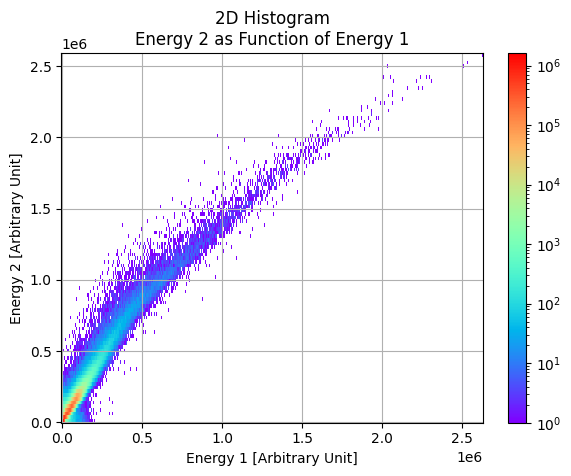

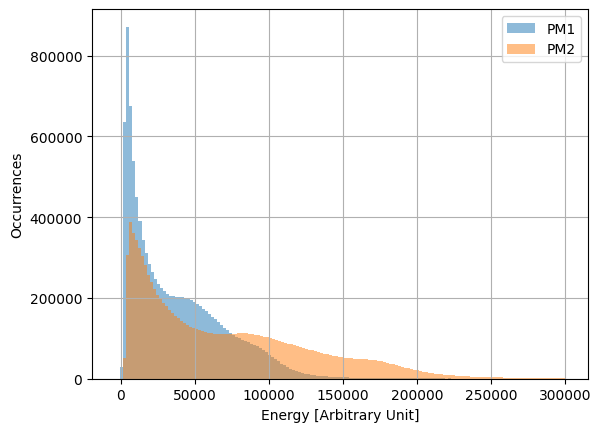

In [5]:
#Energy Analysis

#After correlation only
print('... After correlation only ...')

nrj_max = 300000

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1, nrj2, bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

plt.figure()
plt.hist(nrj1[nrj1 < nrj_max], bins = 150, alpha = 0.5, label = "PM1")
plt.hist(nrj2[nrj2 < nrj_max], bins = 150, alpha = 0.5, label = "PM2")
plt.xlabel("Energy [Arbitrary Unit]")
plt.ylabel("Occurrences")
plt.grid()
plt.legend()
plt.show()

... After correlation and cut on dt ...
Number of events acquired with PM2 after correlation and cut on dt: 0.141918 million


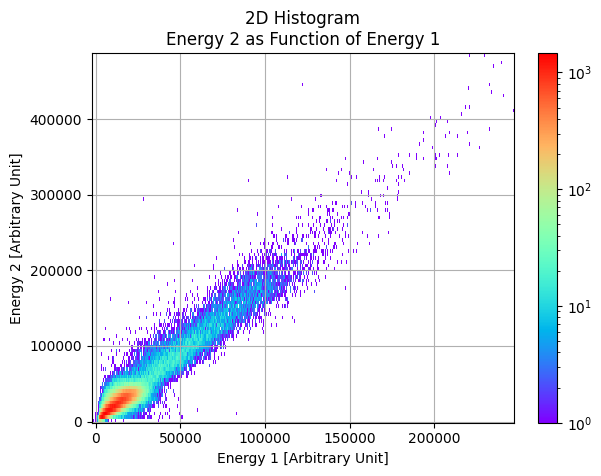

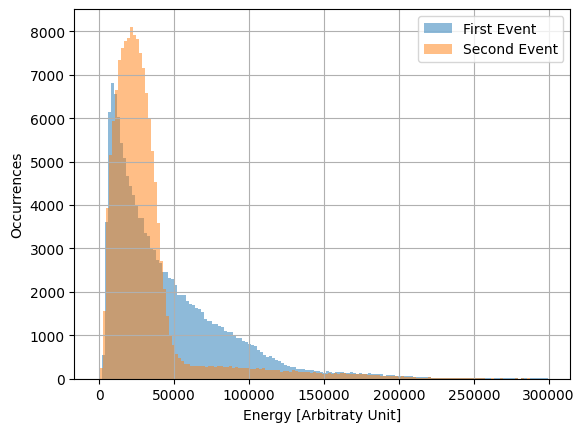

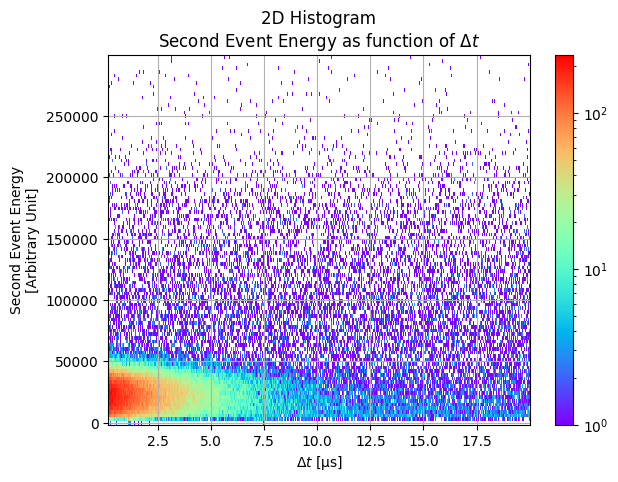

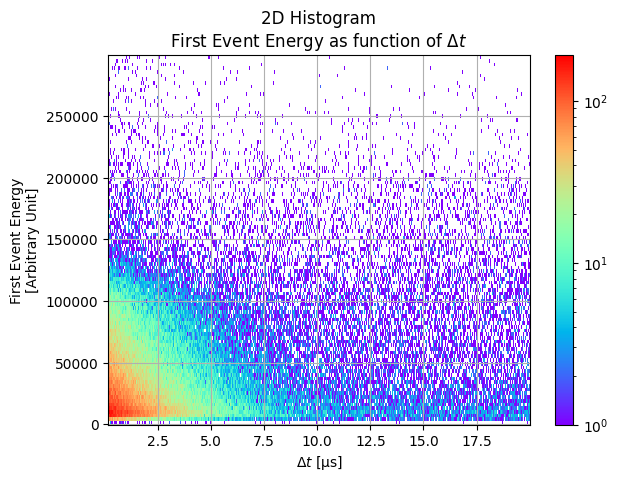

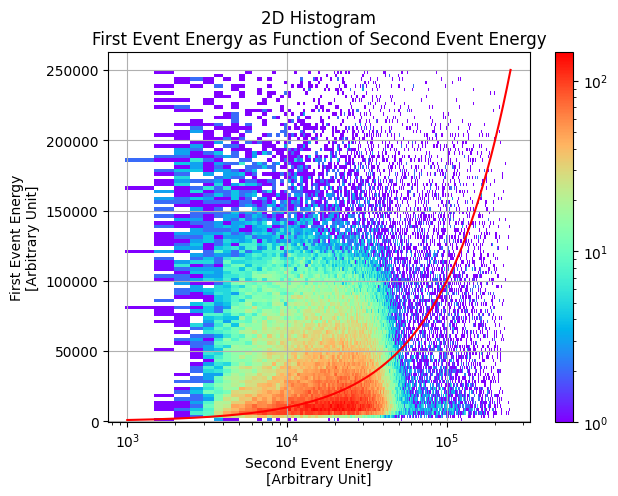

In [6]:
#After correlation and cut on dt
print('... After correlation and cut on dt ...')

dt_max = 20
print("Number of events acquired with PM2 after correlation and cut on dt:", len(dt2[dt2 < 20])/10**6, "million")

#Energy PM1 vs energy PM2
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[1:][(dt2 < dt_max)&(nrj1[1:]<0.25e6)&(nrj2[1:]<0.5e6)], 
                                 nrj2[1:][(dt2 < dt_max)&(nrj1[1:]<0.25e6)&(nrj2[1:]<0.5e6)], 
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon and electron energy
plt.figure()
#plt.hist(nrj2[1:][(nrj2[1:]<nrj_max) & (dt2<dt_max)], bins=150, label="Second Event", alpha = 0.5)
#plt.hist(nrj2[:-1][(nrj2[:-1]<nrj_max)  & (dt2<dt_max)], bins=150, label="First Event", alpha = 0.5)
plt.hist(nrj2[(nrj2<nrj_max) & (np.append(dt2, np.nan)<dt_max)], bins=150, label="First Event", alpha = 0.5)
plt.hist(nrj2[(nrj2<nrj_max) & (np.insert(dt2, 0, np.nan)<dt_max)], bins=150, label="Second Event", alpha = 0.5)
plt.xlabel('Energy [Arbitraty Unit]')
plt.ylabel('Occurrences')
plt.legend()
plt.grid()
plt.show()

#Electron as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(nrj2[1:]<nrj_max) & (dt2<dt_max)], 
                                 nrj2[1:][(nrj2[1:]<nrj_max) & (dt2<dt_max)],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nSecond Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(nrj2[:-1]<nrj_max) & (dt2<dt_max)], 
                                 nrj2[:-1][(nrj2[:-1]<nrj_max) & (dt2<dt_max)],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of electron

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)],
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)],  
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as Function of Second Event Energy')
ax1.grid()
ax1.plot(np.linspace(1000, 250000, 10000),np.linspace(1000,250000, 10000),c='r')
ax1.set_xscale("log")
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

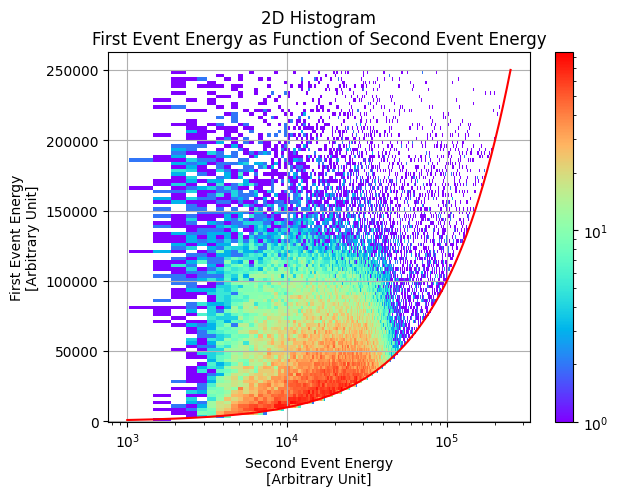

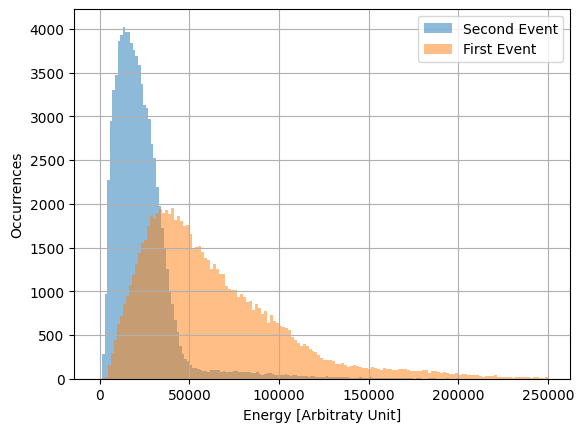

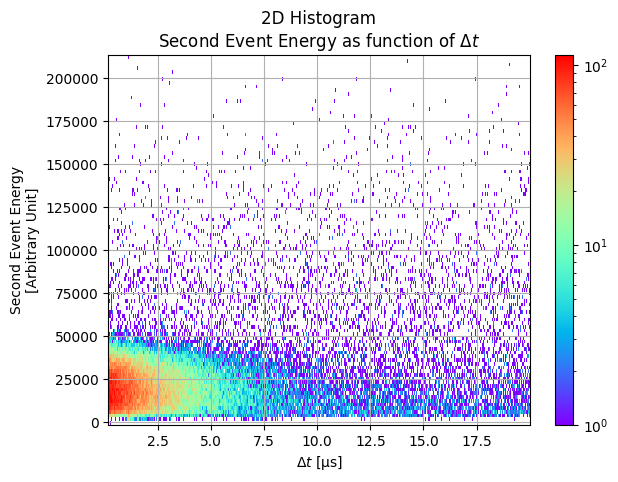

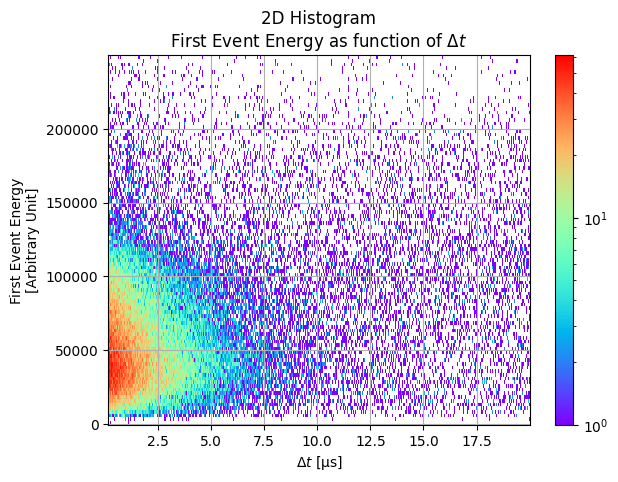

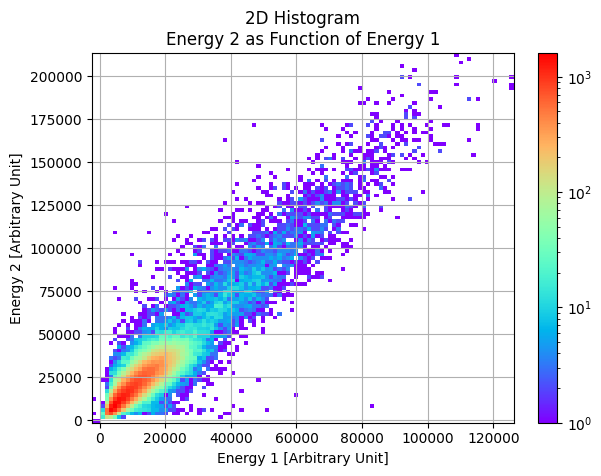

/tmp/ipykernel_209217/3491393612.py:77: RuntimeWarning: invalid value encountered in sqrt
  popt, cov = curve_fit(BF.lin, xe_1, ye_1, sigma = np.sqrt(ye_1), absolute_sigma = True, p0 = np.array([1.7, 0]))


1.7
0.0


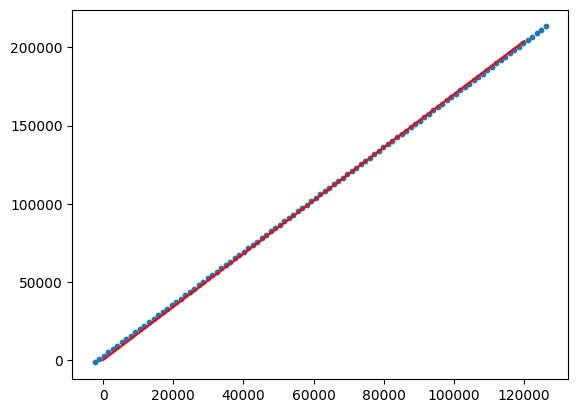

In [7]:
#After correlation, cut on dt and cut on electron/muon energy

mask = nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)] < nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)]

#Muon as function of electron

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask],
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask],  
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as Function of Second Event Energy')
ax1.grid()
ax1.plot(np.linspace(1000, 250000, 10000),np.linspace(1000,250000, 10000),c='r')
ax1.set_xscale("log")
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon and electron energy
plt.figure()
plt.hist(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], bins=150, label="Second Event", alpha = 0.5)
plt.hist(nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], bins=150, label="First Event", alpha = 0.5)
#plt.hist(nrj2[(nrj2<nrj_max) & (np.append(dt2, np.nan)<dt_max)], bins=150, label="First Event", alpha = 0.5)
#plt.hist(nrj2[(nrj2<nrj_max) & (np.insert(dt2, 0, np.nan)<dt_max)], bins=150, label="Second Event", alpha = 0.5)
plt.xlabel('Energy [Arbitraty Unit]')
plt.ylabel('Occurrences')
plt.legend()
plt.grid()
plt.show()

#Electron as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], 
                                 nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nSecond Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of dt
fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], 
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Energy PM1 vs energy PM2

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], 
                                 nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], 
                                 bins =(100,100))

pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
#ax1.plot([0,120000], [0, 1.8*120000], c='k')
#ax1.plot([0,120000], [0+beta, (alpha*120000)+beta], c='k', alpha = 0.5)
#ax1.plot([0,120000], [0-beta, (alpha*120000)-beta], c='k', alpha = 0.5)
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

popt, cov = curve_fit(BF.lin, xe_1, ye_1, sigma = np.sqrt(ye_1), absolute_sigma = True, p0 = np.array([1.7, 0]))
a = popt[0]
b = popt[1]
print(a)
print(b)

plt.figure()
plt.scatter(xe_1, ye_1, s=10)
plt.plot(np.array([0, 120000]), a*np.array([0, 120000])+b, c='r')
plt.show()

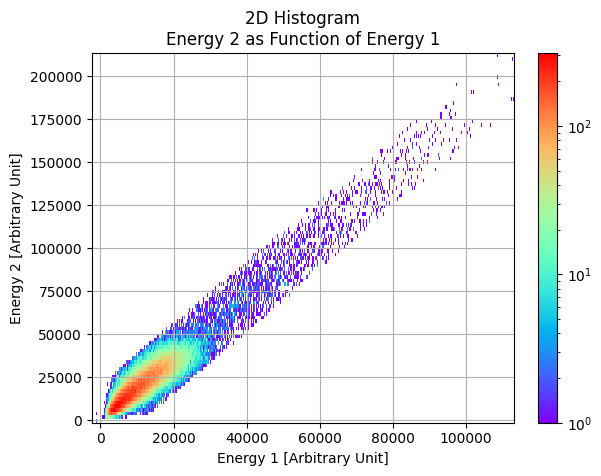

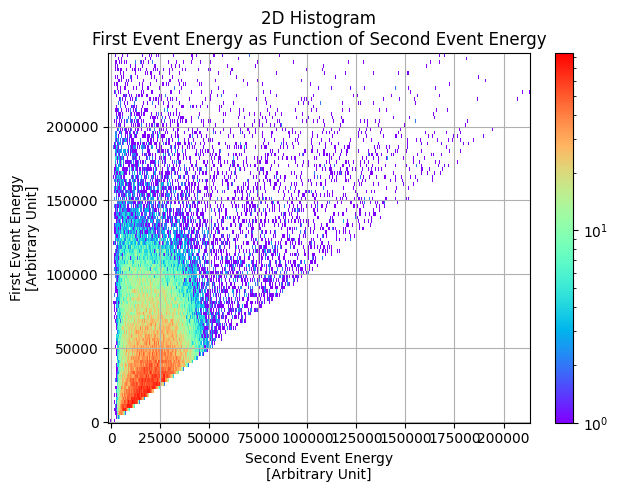

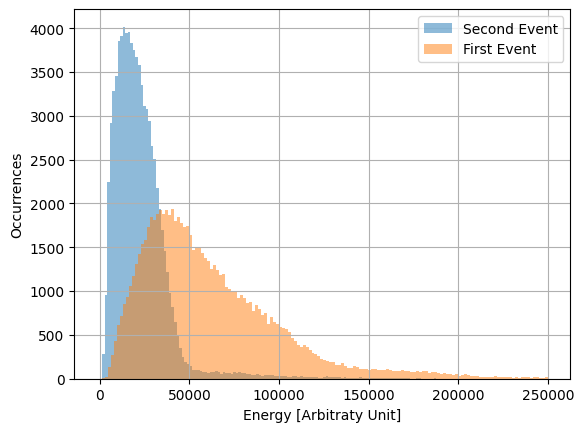

In [54]:
#Correlation, cut on dt, Eµ>Ee and linearity

#Energy PM1 vs energy PM2

alpha = 1.8
beta = 20000

mask2 = (alpha*nrj1[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]+beta>=nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask])&(alpha*nrj1[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]-beta<=nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask])

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2], 
                                 nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2], 
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 2 as Function of Energy 1')
ax1.grid()
#ax1.plot([0,120000], [0, 1.8*120000], c='k')
#ax1.plot([0,120000], [0+beta, (alpha*120000)+beta], c='k', alpha = 0.5)
#ax1.plot([0,120000], [0-beta, (alpha*120000)-beta], c='k', alpha = 0.5)
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

#Muon as function of electron

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2],
                                 nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2],  
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as Function of Second Event Energy')
ax1.grid()
#ax1.plot(np.linspace(1000, 250000, 10000),np.linspace(1000,250000, 10000),c='r')
#ax1.set_xscale("log")
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()


#Muon and electron energy

plt.figure()
plt.hist(nrj2[1:][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2], bins=150, label="Second Event", alpha = 0.5)
plt.hist(nrj2[:-1][(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask][mask2], bins=150, label="First Event", alpha = 0.5)
#plt.hist(nrj2[(nrj2<nrj_max) & (np.append(dt2, np.nan)<dt_max)], bins=150, label="First Event", alpha = 0.5)
#plt.hist(nrj2[(nrj2<nrj_max) & (np.insert(dt2, 0, np.nan)<dt_max)], bins=150, label="Second Event", alpha = 0.5)
plt.xlabel('Energy [Arbitraty Unit]')
plt.ylabel('Occurrences')
plt.legend()
plt.grid()
plt.show()

/home/hind/Documents/Cours/Cours M2/TL/BigMuoneXperiment/BigFunctions.py:5: RuntimeWarning: overflow encountered in exp
  def exp2(t, N0, lam1, lam2, C) : return N0*np.exp(-lam1*t) + 1.3475*N0*np.exp(-lam2*t) + C
/home/hind/Documents/Cours/Cours M2/TL/BigMuoneXperiment/BigFunctions.py:5: RuntimeWarning: overflow encountered in multiply
  def exp2(t, N0, lam1, lam2, C) : return N0*np.exp(-lam1*t) + 1.3475*N0*np.exp(-lam2*t) + C


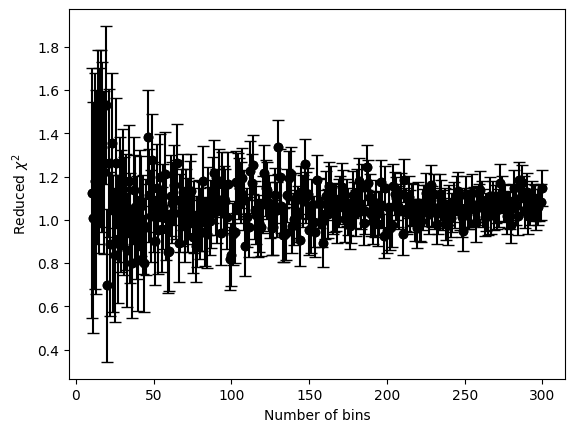

1.0001790380325395
Closest chi2 to 1: [[1.00017904]] +/- [[0.10752067]]
Corresponding number of bins [[177]]


In [9]:
#Bins optimisation

dt_max = 20
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]

plt.figure()
N_bins = np.array(range(10,301))
chi2_lst = []
chi2_err_lst = []

for n in N_bins :
    hist = np.histogram(dt, bins = n)
    x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
    y = hist[0]
    y_err = np.sqrt(y)

    popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
    N0 = popt[0]
    lam1 = popt[1]
    lam2 = popt[2]
    CC = popt[3]

    chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
    chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]

    chi2_lst.append(chi2)
    chi2_err_lst.append(chi2_err)

    plt.errorbar(n, chi2, yerr = chi2_err, linestyle = 'None', fmt='o', capsize=4, c='k')
    plt.scatter(n, chi2, c='k')

plt.xlabel("Number of bins")
plt.ylabel("Reduced $\chi^2$")
plt.show()

chi2_lst = np.array(chi2_lst)
chi2_err_lst = np.array(chi2_err_lst)
print(min(np.abs(1-chi2_lst))+1)

print("Closest chi2 to 1:", chi2_lst[np.argwhere(chi2_lst == min(np.abs(1-chi2_lst))+1)], "+/-", chi2_err_lst[np.argwhere(chi2_lst == min(np.abs(1-chi2_lst))+1)])
print("Corresponding number of bins", N_bins[np.argwhere(chi2_lst == min(np.abs(1-chi2_lst))+1)]) 

Number of events acquired with PM2 after correlation cut on dt and energies: 0.082345 million
... Fit with one exponential ...
chi2 =  1.0453076403284285 +/- 0.10721125348377948


... Fit with two exponentials ...
chi2 =  1.0001790380325395 +/- 0.10752066611409407


/tmp/ipykernel_201989/3840398382.py:46: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k', label = 'Data')


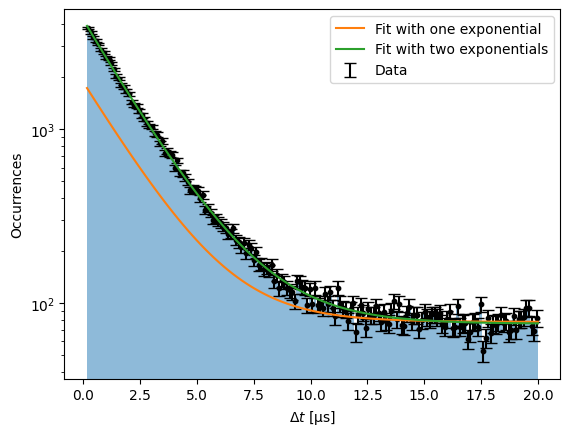

In [10]:
#dt Analysis 

dt_max = 20
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]
print("Number of events acquired with PM2 after correlation cut on dt and energies:", len(dt)/10**6, "million")

N_bins = 177
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With one exponential
popt, cov = curve_fit(BF.exp1, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 400]))
N0 = popt[0]
lam = popt[1]
C = popt[2]
lam_err = cov[1,1]

chi2 = BF.chi2_norm(y, BF.exp1(x, N0, lam, C), y_err, 3)[0]
chi2_err = BF.chi2_norm(y, BF.exp1(x, N0, lam, C), y_err, 3)[1]
print("... Fit with one exponential ...")
print("chi2 = ", chi2, '+/-', chi2_err)
print('\n')

#With two exponentials
popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam1_err = np.sqrt(cov[1,1])
lam2 = popt[2]
lam2_err = np.sqrt(cov[2,2])
CC = popt[3]

chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

#-------------------------------------------------------

plt.figure()
plt.hist(dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask], bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k', label = 'Data')
plt.scatter(x, y, c='k', s=10)
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp1(np.linspace(min(dt), max(dt), 100), N0, lam, C), 
                     label = 'Fit with one exponential')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp2(np.linspace(min(dt), max(dt), 100), N0, lam1, lam2, CC), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
#dt Analysis 

dt_max = np.array([5, 10, 15, 20])
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]
print("Number of events acquired with PM2 after correlation cut on dt and energies:", len(dt)/10**6, "million")

N_bins = 150
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With two exponentials
popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam1_err = np.sqrt(cov[1,1])
lam2 = popt[2]
lam2_err = np.sqrt(cov[2,2])
CC = popt[3]

chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_209217/18748068.py", line 4, in <module>
    dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]
ValueError: operands could not be broadcast together with shapes (11148349,) (2,) 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/hind/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.struc

In [11]:
tau = 1/lam
tau_err = lam_err/lam**2

tau1 = 1/lam1
tau1_err = lam1_err/lam1**2

tau2 = 1/lam2
tau2_err = lam2_err/lam2**2

print("... Fit with one exponential ...")
print('tau = ', tau, '+/-', tau_err, 'µs')
print('\n')
print('... Fit with two exponentials ...')
print('tau1 = ', tau1, '+/-', tau1_err, 'µs')
print('tau2 = ', tau2, '+/-', tau2_err, 'µs')

... Fit with one exponential ...
tau =  2.023804371924896 +/- 2.9470339632968485e-05 µs


... Fit with two exponentials ...
tau1 =  1.6142233129161003 +/- 0.07253490670675761 µs
tau2 =  2.282644057161969 +/- 0.03940863562417091 µs


... Fit with one exponential ...
chi2 =  1.1402428512628409 +/- 0.21821789023599236


... Fit with two exponentials ...
chi2 =  1.0648136814293978 +/- 0.2208630521496931


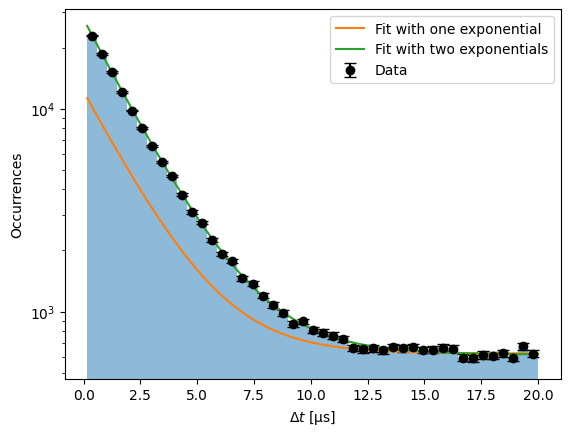

In [58]:
#dt Analysis 

dt_max = 20
dt = dt2[dt2 < dt_max]

N_bins = 45
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With one exponential
popt, cov = curve_fit(BF.exp1, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 400]))
N0 = popt[0]
lam = popt[1]
C = popt[2]
lam_err = cov[1,1]

chi2 = BF.chi2_norm(y, BF.exp1(x, N0, lam, C), y_err, 3)[0]
chi2_err = BF.chi2_norm(y, BF.exp1(x, N0, lam, C), y_err, 3)[1]
print("... Fit with one exponential ...")
print("chi2 = ", chi2, '+/-', chi2_err)
print('\n')

#With two exponentials
popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam1_err = np.sqrt(cov[1,1])
lam2 = popt[2]
lam2_err = np.sqrt(cov[2,2])
CC = popt[3]
CC_err = np.sqrt(cov[3,3])

chi2 = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp2(x, N0, lam1, lam2, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

#-------------------------------------------------------

plt.figure()
plt.hist(dt2[dt2 < dt_max], bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='o', capsize=4, c='k', label = 'Data')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp1(np.linspace(min(dt), max(dt), 100), N0, lam, C), 
                     label = 'Fit with one exponential')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp2(np.linspace(min(dt), max(dt), 100), N0, lam1, lam2, CC), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()

In [59]:
tau = 1/lam
tau_err = lam_err/lam**2

tau1 = 1/lam1
tau1_err = lam1_err/lam1**2

tau2 = 1/lam2
tau2_err = lam2_err/lam2**2

print("... Fit with one exponential ...")
print('tau = ', tau, '+/-', tau_err, 'µs')
print('\n')
print('... Fit with two exponentials ...')
print('tau1 = ', tau1, '+/-', tau1_err, 'µs')
print('tau2 = ', tau2, '+/-', tau2_err, 'µs')
print("C =", CC, '+/-', CC_err)

... Fit with one exponential ...
tau =  2.032800984498693 +/- 1.882290381447346e-05 µs


... Fit with two exponentials ...
tau1 =  2.3120490744600186 +/- 0.06527404263784593 µs
tau2 =  1.804325308957612 +/- 0.05861568391566418 µs
C = 613.4749564252669 +/- 6.800197384234117


... Fit with two exponentials ...
chi2 =  1.0464257592043424 +/- 0.10752066611409407
0.4932758779833086 17.404873170885406


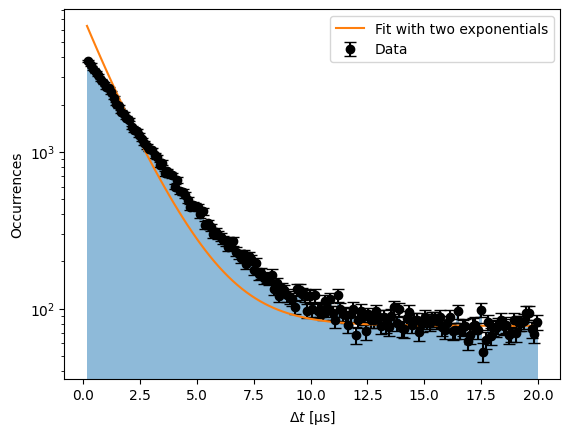

In [21]:
#With lam and lam_c

dt_max = 20
dt = dt2[(dt2<dt_max) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask]

N_bins = 177
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

popt, cov = curve_fit(BF.exp3, x, y, sigma=y_err, absolute_sigma = True, p0=np.array([20000, 2, 1, 600]))
N0 = popt[0]
lam = popt[1]
lam_err = np.sqrt(cov[1,1])
lam_c = popt[2]
lam_c_err = np.sqrt(cov[2,2])
CC = popt[3]
CC_err = np.sqrt(cov[3,3])

chi2 = BF.chi2_norm(y, BF.exp3(x, N0, lam, lam_c, CC), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp3(x, N0, lam, lam_c, CC), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

print(lam, lam_c)

plt.figure()
plt.hist(dt, bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='o', capsize=4, c='k', label = 'Data')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp3(np.linspace(min(dt), max(dt), 100), N0, lam1, lam2, CC), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.show()

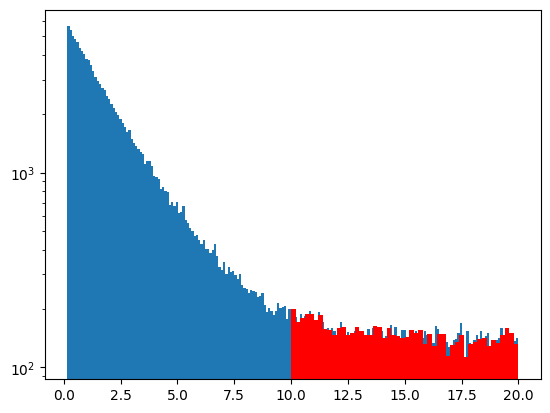

C = 185.57499347677305 +/- 2.153920811216349


In [92]:
def constant(x, C) : return C

dt_min = 10
dt_max = 20
mask3 = nrj2[1:][(dt2<dt_max) & (dt2>dt_min) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)] < nrj2[:-1][(dt2<dt_max) & (dt2>dt_min) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)]

dt_C = dt2[(dt2<dt_max) & (dt2>dt_min) & (nrj2[:-1]<0.25e6) & (nrj2[1:]<0.25e6)][mask3]
N_bins = 40
hist = np.histogram(dt_C, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

popt, cov = curve_fit(constant, x, y, p0 = np.array([600]), sigma = y_err, absolute_sigma = True)
C = popt[0]
C_err = np.sqrt(cov[0,0])

plt.figure()
plt.hist(dt, bins = 200)
plt.hist(dt_C, bins = 50, color = 'r')
#plt.plot([dt_min, dt_max], [C, C])
plt.yscale('log')
plt.show()

print("C =", C, "+/-", C_err)